In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
torch.cuda.is_available()

True

In [25]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} - {torch.cuda.get_device_name(0)}")

Using device: cuda - NVIDIA GeForce RTX 3070


In [26]:
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [27]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [28]:
df.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

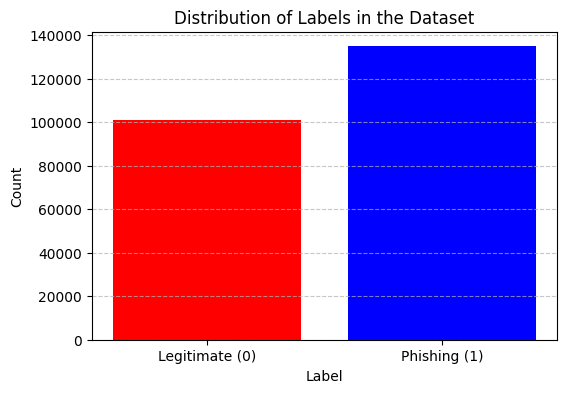

In [29]:
label_counts = df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
plt.xticks([0, 1], ['Legitimate (0)', 'Phishing (1)'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
df.dtypes

FILENAME                       object
URL                            object
URLLength                       int64
Domain                         object
DomainLength                    int64
IsDomainIP                      int64
TLD                            object
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode  

In [31]:
# Drop non-numeric columns
df = df.drop(columns=['FILENAME', 'URL', 'Domain', 'TLD', "Title"])

# Separate features and target
X = df.drop(columns=['label']).values
y = df['label'].values


In [32]:
X

array([[ 31.,  24.,   0., ..., 119.,   0., 124.],
       [ 23.,  16.,   0., ...,  39.,   0., 217.],
       [ 29.,  22.,   0., ...,  42.,   2.,   5.],
       ...,
       [ 30.,  23.,   0., ...,  58.,   2.,  67.],
       [ 55.,  47.,   0., ...,   0.,   0.,   0.],
       [ 33.,  26.,   0., ..., 256.,   0., 261.]], shape=(235795, 50))

In [33]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
# Define a simple feed-forward neural network
class PhishingModel(nn.Module):
    def __init__(self, input_size):
        super(PhishingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [37]:
# Initialize model, loss function, and optimizer
model = PhishingModel(input_size=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    
    # Evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {test_losses[-1]:.4f}, Val Acc: {test_accuracies[-1]:.4f}")

Epoch 1/20, Train Loss: 0.0043, Train Acc: 0.9993, Val Loss: 0.0005, Val Acc: 0.9999
Epoch 2/20, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0009, Val Acc: 0.9997
Epoch 3/20, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0004, Val Acc: 0.9999
Epoch 4/20, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.0003, Val Acc: 0.9999
Epoch 5/20, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 6/20, Train Loss: 0.0002, Train Acc: 0.9999, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 7/20, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.0005, Val Acc: 0.9999
Epoch 8/20, Train Loss: 0.0002, Train Acc: 0.9999, Val Loss: 0.0004, Val Acc: 0.9999
Epoch 9/20, Train Loss: 0.0002, Train Acc: 0.9999, Val Loss: 0.0006, Val Acc: 0.9999
Epoch 10/20, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 0.9999
Epoch 11/20, Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0009, Val Acc: 0.9999
Epoch 12/20, Train Loss: 0.0002, Train Acc: 0.9999, Val Loss: 0

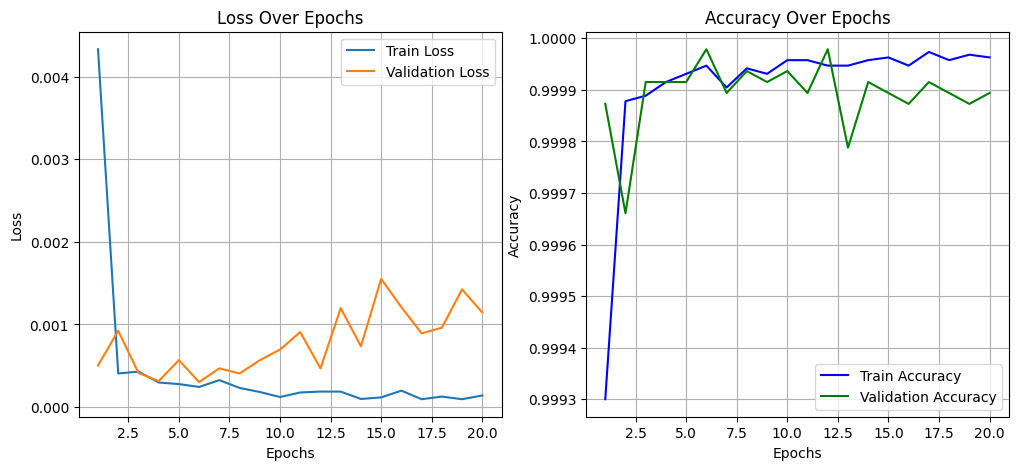

In [41]:

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy Over Epochs')
plt.show()

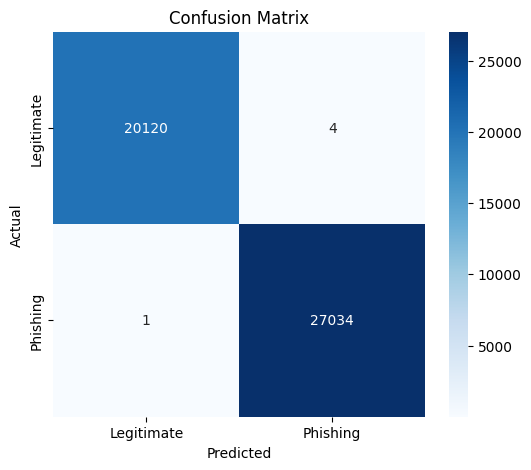

In [39]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()